In [1]:
import os, uuid, sys
import subprocess
import tqdm
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
import seaborn as sns

from azure.storage.blob import BlockBlobService, PublicAccess

%matplotlib inline

In [5]:
with open('credentials.json') as f:
    data = json.load(f)
    accountName = data['accountName']
    accountKey = data['accountKey']

In [6]:
from tqdm import tqdm, tqdm_notebook

import astropy

import tensorflow as tf

from scipy import sparse
from astropy.io import fits
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17275808185928200563, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9515880820093114723
 physical_device_desc: "device: XLA_CPU device"]

In [8]:
with open('credentials.json') as f:
    data = json.load(f)
    accountName = data['accountName']
    accountKey = data['accountKey']

In [9]:
#!pip install azure-storage-blob
# Create the BlockBlockService that is used to call the Blob service 
# for the storage account
block_blob_service = BlockBlobService(account_name=accountName, 
                                      account_key=accountKey)

# Create a container called 'processed' (it is already there).
ContainerNameFits = 'uncompressed'
container_name_fits = ContainerNameFits
#block_blob_service.create_container(container_name)

# Set the permission so the blobs are public.
block_blob_service.set_container_acl(container_name_fits, 
                                     public_access=PublicAccess.Container)

In [11]:
# Paths
PROJECT_DIR = "/Users/rmunoz/Github/personal/eso_uves"
# Data dir
DATA_DIR = os.path.join(PROJECT_DIR, "data")
# Model checkpoints
CHECKPOINT_DIR = os.path.join(PROJECT_DIR, "data/descriptors")
# Number of images to process
N_FILES=51

# Model layer name to extract features
MODEL_LAYER_NAME ='avg_pool'
# Number of cpu cores
N_CPU = 2

In [12]:
if not os.path.exists(CHECKPOINT_DIR):
    os.mkdir(CHECKPOINT_DIR)

In [13]:
#config = tf.ConfigProto( device_count = {'CPU': N_CPU} )
#sess = tf.Session(config=config)
#tf.keras.backend.set_session(sess)

In [14]:
# Define the model
model = tf.keras.applications.resnet50.ResNet50(include_top=True, 
                                                 weights='imagenet', 
                                                 classes=1000)

feature_layer_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.get_layer(MODEL_LAYER_NAME).output)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [16]:
def get_descriptor(model, out_layer, data_input):
    feature_layer_model = tf.keras.backend.function([model.layers[0].input],
                                      [model.get_layer(out_layer).output])
    layer_output = feature_layer_model([data_input])[0]
    return layer_output

In [17]:
model.layers[0].input

<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>

In [18]:
feature_layer_model.output.shape[-1].value
#feature_layer_model.summary()

2048

In [19]:
# Create a list "filelist" with the blob content
# inside the "Azure:container/folder" location 
def BlobList(container, folder, filelist, verbose=False):
    
    gen = block_blob_service.list_blobs(container, 
                                        prefix=folder)
    
    for blob in gen:
        file = str(blob.name).replace(folder,'')
        filelist.append(file)
        if verbose == True:
            print("\t Blob name: " + blob.name)
        
    return filelist

# Download a file "blobfile" from "container" and save it 
# in the file "locfile"
def DownBlob(container, blobfile, locfile, verbose=False):
    
    if verbose == True:
        print('Downloading ' + blobfile + ' to ' + locfile)
    
    block_blob_service.get_blob_to_path(container, 
                                        blobfile, 
                                        locfile)

# Uncompress data 
def UnCompress(file, verbose=False):
    
    if verbose == True:
        print('Uncompressing ' + file)
    
    subprocess.call(['uncompress', file])
    #os.popen('uncompress ' + file)

# Upload file "locfile" to the blob "blobfile" in container
def UpBlob(container, blobfile, locfile, verbose=False):
    
    if verbose == True:
        print('Uploading ' + locfile + ' to ' + blobfile)
        
    block_blob_service.create_blob_from_path(container, 
                                             blobfile, 
                                             locfile, 
                                             validate_content=True)

In [20]:
# Get the .fits image from blob storage and return the associated data
# It uses the DownBlob function
def GetImage(imname, container, blob_sub_dir, arm, verbose=False):
    blobfile = os.path.join(blob_sub_dir,imname)
    locfile = '../Temp/' + imname
    try:
        DownBlob(container, blobfile, locfile, verbose=False)
    except:
        print('A problem in DownBlob.')
    hdu = fits.open(locfile)
    data = hdu[arm].data
    
    data = data/500.
    
    image = np.empty((3,data.shape[0],data.shape[1]))
    image[0] = np.copy(data)
    image[1] = np.copy(data)
    image[2] = np.copy(data)
    image = np.swapaxes(image,0,1)
    image = np.swapaxes(image,1,2)
    if arm == 0 or arm == 2:
        subprocess.call(['rm', locfile])
    return image

In [21]:
def process_imgs(dir_list, layer,
                 container, blob_sub_dir, arm,
                 top_k=5, xdim=224, ydim=224,
                 show_output=False, save_resized=False):

    descriptor_len = feature_layer_model.output.shape[-1].value
    descriptors = np.zeros((len(dir_list), descriptor_len))
    
    with tqdm(total=len(dir_list)) as pbar:
        for img_idx in range(0, len(dir_list)):
            imgname = dir_list[img_idx]
            img = GetImage(imgname, container, blob_sub_dir, arm)
            #img = resize_img(imgpath, xdim, ydim, save=save_resized)
            img = np.expand_dims(img, axis=0)
            #desc = feature_layer_model.predict(img)
            desc = get_descriptor(model, layer, img)

            descriptors[img_idx, :] = desc
            pbar.update(1)
            
            # only for model verification (irrelevant otherwise)
            #if show_output:
            #    top_k_preds = pred.argsort()[::-1][:top_k]
            #    for p in top_k_preds:
            #        print(classes_map[p], pred[p])

            #    with PIL.Image.open(IMG_DIRECTORY_LIST[img_idx]) as im:
            #        if im.mode != 'RGB':
            #            im = im.convert(mode='RGB')
            #        img = np.frombuffer(im.tobytes(), dtype='uint8').reshape((im.size[1], im.size[0], 3))
            #        im = img
                    
            #        plt.figure()
            #        plt.imshow(im)
            #        plt.show()

    return descriptors

In [22]:
def get_corrupted_images(image_type):
    '''
    Function that reads the ESO archive file and returns the 
    '''
    uves_flag_file=os.path.join(DATA_DIR, 'UVES_hidden_flag_results.txt')
    uves_flag_df=pd.read_csv(uves_flag_file, comment='#', sep=';')
    uves_flag_df['filename'] = uves_flag_df['filename']+'.fits'
    
    corrupted_df = uves_flag_df[(uves_flag_df['image_type'] == image_type) & (uves_flag_df['flag'] == 'CORRUPTED')]

    result = list(corrupted_df['filename'])
    
    return result

In [32]:
container_name_fits

'uncompressed'

In [23]:
# Read the file list in the blob and save it as a dataframe
#Test
BlobSubDirs = 'test'
#BlobSubDirs = 'bias_blue'
arm = 0
blob_sub_dir = BlobSubDirs
FolderRem = blob_sub_dir + '/'
folder_rem = FolderRem
fits_files = []
BlobList(container_name_fits, folder_rem, fits_files)

print(len(fits_files))
IMG_DIRECTORY_LIST = fits_files[0:N_FILES]
#IMG_DIRECTORY_LIST.extend(['UVES.2010-10-26T09:32:08.896.fits', 'UVES.2010-10-26T09:32:54.480.fits', 'UVES.2010-10-26T09:33:40.043.fits'])
IMG_DIRECTORY_LIST.extend(get_corrupted_images('bias_blue'))
df_uves = pd.DataFrame(IMG_DIRECTORY_LIST, columns = ['filename'])
print(df_uves.head())

0
                            filename
0  UVES.2010-10-26T09:32:08.896.fits
1  UVES.2010-10-26T09:32:54.480.fits
2  UVES.2010-10-26T09:33:40.043.fits
3  UVES.2010-10-26T09:34:25.617.fits
4  UVES.2010-10-26T09:35:11.190.fits


In [24]:
img_filenames_file = os.path.join(CHECKPOINT_DIR, 'img_filenames_resNet50_N'+str(N_FILES)+'.csv')
df_uves.to_csv(img_filenames_file, header=True, index=False)

In [29]:
IMG_DIRECTORY_LIST

['UVES.2010-10-26T09:32:08.896.fits',
 'UVES.2010-10-26T09:32:54.480.fits',
 'UVES.2010-10-26T09:33:40.043.fits',
 'UVES.2010-10-26T09:34:25.617.fits',
 'UVES.2010-10-26T09:35:11.190.fits',
 'UVES.2010-10-27T09:03:28.338.fits',
 'UVES.2010-10-27T09:04:13.922.fits',
 'UVES.2010-10-27T09:04:59.495.fits',
 'UVES.2010-10-27T09:05:45.069.fits',
 'UVES.2010-10-27T09:06:30.642.fits',
 'UVES.2012-02-17T10:05:06.556.fits',
 'UVES.2012-02-17T10:05:52.140.fits',
 'UVES.2012-02-17T10:06:37.713.fits',
 'UVES.2012-02-17T10:07:23.287.fits',
 'UVES.2012-02-17T10:08:08.860.fits',
 'UVES.2015-05-26T22:32:32.321.fits',
 'UVES.2015-12-05T09:37:16.660.fits',
 'UVES.2015-12-05T09:38:02.244.fits',
 'UVES.2015-12-05T09:38:47.818.fits',
 'UVES.2015-12-05T09:39:33.392.fits',
 'UVES.2015-12-05T09:40:18.967.fits',
 'UVES.2015-12-06T09:01:10.063.fits',
 'UVES.2015-12-06T09:01:55.647.fits',
 'UVES.2015-12-06T09:02:41.222.fits',
 'UVES.2015-12-06T09:03:26.796.fits',
 'UVES.2015-12-06T09:04:12.380.fits',
 'UVES.2015-

In [26]:
# If no descriptors present in local machine
descs_resNet50 = process_imgs(IMG_DIRECTORY_LIST, MODEL_LAYER_NAME, container_name_fits, blob_sub_dir, arm) #, save_resized=True) # Already resized in Gotham
np_descs = np.array(descs_resNet50)
np.save(os.path.join(CHECKPOINT_DIR, 'descriptors_resNet50_N'+str(N_FILES)), descs_resNet50) 

  0%|          | 0/46 [00:00<?, ?it/s]Client-Request-ID=f17423ba-5e53-11ea-b56d-acde48001122 Retry policy did not allow for a retry: Server-Timestamp=Wed, 04 Mar 2020 20:08:41 GMT, Server-Request-ID=897172d5-b01e-0077-2e60-f2b98b000000, HTTP status code=404, Exception=The specified blob does not exist.<?xml version="1.0" encoding="utf-8"?><Error><Code>BlobNotFound</Code><Message>The specified blob does not exist.RequestId:897172d5-b01e-0077-2e60-f2b98b000000Time:2020-03-04T20:08:41.5381866Z</Message></Error>.


A problem in DownBlob.


OSError: Empty or corrupt FITS file

In [94]:
def flatten_descs(descs, IMG_DIRECTORY_LIST):
    np_descs = descs
    flat_descs = []
    names = []
    for row_idx in range(np_descs.shape[0]):
        row = np_descs[row_idx]
        n_row = row.flatten()
        flat_descs.append(n_row)
        names.append(IMG_DIRECTORY_LIST[row_idx])
        
    return np.array(flat_descs), np.array(names)

In [97]:
# For performance, we sparsify matrix
flat_descs, names = flatten_descs(descs_resNet50, IMG_DIRECTORY_LIST)  # (n_imgs, (4032, img_name))
d_sparse = sparse.csr_matrix(flat_descs)
print(flat_descs)

[[5.72228339e-03 2.64846464e-03 6.50136545e-02 ... 2.32088137e+00
  1.93038408e-03 0.00000000e+00]
 [3.30613228e-03 4.64101555e-03 5.82313836e-02 ... 2.26690650e+00
  6.32139563e-04 4.77003887e-05]
 [1.55625097e-03 3.04101093e-04 5.79929724e-02 ... 2.19668365e+00
  1.43807309e-04 0.00000000e+00]
 ...
 [6.51727198e-04 7.83605428e-05 5.49474880e-02 ... 2.16036272e+00
  0.00000000e+00 0.00000000e+00]
 [2.03578340e-04 2.61475798e-03 5.57556711e-02 ... 2.10727286e+00
  6.30590439e-05 0.00000000e+00]
 [2.25306349e-03 2.09301594e-03 5.58142439e-02 ... 2.05081582e+00
  1.51010300e-03 0.00000000e+00]]


In [1]:
print(len(flat_descs),flat_descs.shape)

NameError: name 'flat_descs' is not defined

In [99]:
# Compute all-vs-all cosine similarity (should be query-vs-all at test-time, extra param in c_s(X, Y))
batch_size=2000
if True:
    with tqdm(total=d_sparse.shape[0]) as pbar:
        # All descriptors do not fit at once. We compute and save in segments
        for i in range(0, d_sparse.shape[0], 2000):
            try:
                sims = cosine_similarity(d_sparse, d_sparse[i:i+2000])
            except:
                sims = cosine_similarity(d_sparse, d_sparse[i:])
            np.save(os.path.join(CHECKPOINT_DIR, 'similarities_part_{}'.format(i//2000)), sims)
            pbar.update(2000)

2000it [00:00, 185744.83it/s]         


In [100]:
# Integrate similarity segments in one big tensor, on memory, from saved np files
all_sims = None  # shape (n_imgs, n_imgs)
for i in range(0, d_sparse.shape[0], batch_size):
    try:
        all_sims[0]
        all_sims = np.hstack((all_sims, np.load(os.path.join(CHECKPOINT_DIR, 'similarities_part_{}.npy'.format(i//batch_size)))))
    except:
        all_sims = np.load(os.path.join(CHECKPOINT_DIR, 'similarities_part_{}.npy'.format(i//batch_size)))

In [101]:
# Save the first time
if True:
    np.save(os.path.join(CHECKPOINT_DIR, 'full_descriptors_resNet50'), flat_descs)
    np.save(os.path.join(CHECKPOINT_DIR, 'paths'), names)

In [102]:
similarities= all_sims
np.fill_diagonal(similarities, 1.0)
print("Shape:\t\t\t{}".format(similarities.shape))
print('Mean distance:\t\t{}'.format(np.mean(similarities)))
print('\nPairwise dense output:\n\n{}\n'.format(similarities))

Shape:			(40, 40)
Mean distance:		0.9995580173969918

Pairwise dense output:

[[1.         0.9997727  0.99911277 ... 0.99894505 0.99838849 0.99797677]
 [0.9997727  1.         0.99965811 ... 0.99961952 0.99929589 0.99900668]
 [0.99911277 0.99965811 1.         ... 0.99991678 0.99978303 0.99963522]
 ...
 [0.99894505 0.99961952 0.99991678 ... 1.         0.99991679 0.99979789]
 [0.99838849 0.99929589 0.99978303 ... 0.99991679 1.         0.99995591]
 [0.99797677 0.99900668 0.99963522 ... 0.99979789 0.99995591 1.        ]]



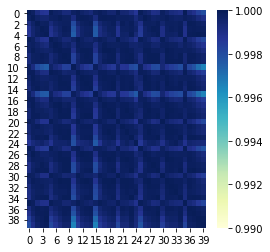

In [114]:
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(similarities, cmap="YlGnBu", vmin=0.99, vmax=1.0)

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [119]:
X = flat_descs
pca = PCA()

In [120]:
scaler = StandardScaler()
X=scaler.fit_transform(X)
print(X)

[[-0.20034648 -0.38955005 -0.36161307 ...  1.18439134  0.44784577
  -0.1855288 ]
 [-0.63036491  0.04986004 -0.82425477 ...  0.52728064 -0.61616135
   0.08806606]
 [-0.94180289 -0.90654412 -0.8405176  ... -0.32763929 -1.01638564
  -0.1855288 ]
 ...
 [-1.10278698 -0.95632587 -1.04826042 ... -0.76982414 -1.13424633
  -0.1855288 ]
 [-1.182547   -0.39698326 -0.99313151 ... -1.4161604  -1.0825648
  -0.1855288 ]
 [-0.81778654 -0.51204116 -0.98913606 ... -2.10349006  0.10339443
  -0.1855288 ]]


In [121]:
pca.fit_transform(X)

array([[-1.16270203e+01, -1.75548785e+01,  9.38757906e+00, ...,
        -5.25538149e-01,  8.85635892e-02,  1.26936739e-14],
       [-1.38232010e+01, -2.62608597e+00,  2.82085815e+00, ...,
        -9.83432165e-01, -1.69512664e-01,  1.26936739e-14],
       [-2.56882533e+01,  9.32748602e+00,  2.92063623e-01, ...,
        -3.02012876e+00, -5.42601089e+00,  1.26936739e-14],
       ...,
       [-2.71969218e+01,  1.68168542e+01,  6.85383120e-01, ...,
        -5.87167493e-01,  1.62413586e+00,  1.26936739e-14],
       [-2.42413217e+01,  2.14619641e+01, -5.53237056e+00, ...,
         5.34361293e-01,  7.48617557e-02,  1.26936739e-14],
       [-1.61744658e+01,  2.06973297e+01, -1.34167323e+01, ...,
         1.01184125e+00,  9.23363245e-01,  1.26936739e-14]])

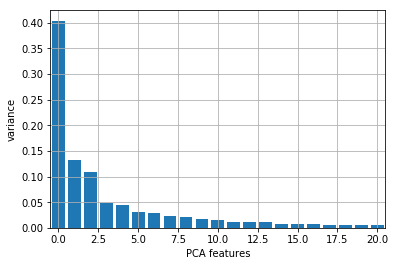

In [139]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel("PCA features")
plt.ylabel("variance")
plt.xlim(-0.5,20.5)
plt.grid()
plt.show()

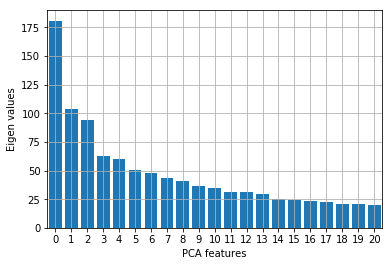

In [140]:
plt.bar(features, pca.singular_values_)
plt.xticks(features)
plt.xlabel("PCA features")
plt.ylabel("Eigen values")
plt.xlim(-0.5,20.5)
plt.grid()
plt.show()

In [146]:
pca.components_.shape

(40, 2048)

In [144]:
pca.n_components_

40

In [318]:
from sklearn.preprocessing import StandardScaler

X = flat_descs.T
X_std = StandardScaler().fit_transform(X)
print(X_std.shape)
print(X_std)

(2048, 40)
[[-0.21466238 -0.2165094  -0.21794421 ... -0.21777241 -0.21830896
  -0.21653174]
 [-0.21806013 -0.21502788 -0.21933654 ... -0.21841073 -0.21561528
  -0.21671115]
 [-0.14912271 -0.15555038 -0.15518925 ... -0.15732571 -0.15624818
  -0.15649246]
 ...
 [ 2.34447485  2.29575694  2.22293332 ...  2.18660332  2.13563254
   2.07980022]
 [-0.21885388 -0.21947714 -0.21951478 ... -0.21849797 -0.21846594
  -0.21736456]
 [-0.2209877  -0.22012579 -0.21967469 ... -0.21849797 -0.21853639
  -0.21905731]]


In [319]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-0.15808636  0.2285235   0.05340326 ...  0.11515004 -0.26399817
  -0.01408933]
 [-0.15814081  0.06455348  0.07111292 ...  0.05687329 -0.01506486
   0.03794761]
 [-0.15812458 -0.1041831   0.11722674 ...  0.00489364 -0.08561391
  -0.16395194]
 ...
 [-0.15811633 -0.15111484  0.19766279 ... -0.19779871 -0.02486921
   0.28022255]
 [-0.15807521 -0.24443337  0.16969188 ...  0.08453563 -0.0760259
  -0.17230554]
 [-0.15803784 -0.30327235  0.13520084 ...  0.07518657 -0.07983361
   0.21792934]]

Eigenvalues 
[4.00012725e+01 1.47414061e-02 1.69110263e-03 8.12047559e-04
 2.86326924e-04 1.79390662e-04 1.11510852e-04 7.06408263e-05
 4.38106995e-05 3.85736010e-05 3.45753180e-05 2.73643114e-05
 2.30027382e-05 2.07484614e-05 1.87109768e-05 1.66640344e-05
 1.50702240e-05 1.29681301e-05 1.25090328e-05 1.19237831e-05
 1.00220435e-05 8.32932292e-06 8.01172424e-06 7.52837089e-06
 1.96610246e-06 2.22487231e-06 2.31724915e-06 2.74123143e-06
 2.91608136e-06 3.22466781e-06 3.44159020e-06 3.752543

In [320]:
U,s,V = np.linalg.svd(X_std.T)
print(U)
print(s)

[[-0.15808636 -0.2285235   0.05340326 ...  0.03336717 -0.30137791
  -0.07543897]
 [-0.15814081 -0.06455348  0.07111292 ...  0.0094793  -0.02733905
  -0.2580024 ]
 [-0.15812458  0.1041831   0.11722674 ... -0.24106812 -0.02449393
   0.18323737]
 ...
 [-0.15811633  0.15111484  0.19766279 ...  0.40590386 -0.1131164
  -0.07193814]
 [-0.15807521  0.24443337  0.16969188 ...  0.0654758  -0.07031644
  -0.158001  ]
 [-0.15803784  0.30327235  0.13520084 ... -0.06387022  0.21645267
   0.00953234]]
[2.86151367e+02 5.49323751e+00 1.86056096e+00 1.28928715e+00
 7.65579005e-01 6.05980763e-01 4.77768472e-01 3.80265396e-01
 2.99467030e-01 2.80998508e-01 2.66036982e-01 2.36674345e-01
 2.16994482e-01 2.06087604e-01 1.95707357e-01 1.84692389e-01
 1.75638118e-01 1.62928703e-01 1.60018718e-01 1.56230547e-01
 1.43231013e-01 1.30576123e-01 1.28062483e-01 1.24139338e-01
 1.16585122e-01 1.12682829e-01 1.10403470e-01 1.07471631e-01
 1.04792643e-01 1.01542478e-01 9.46210330e-02 9.30950353e-02
 8.76439220e-02 8.393

In [335]:
#A = X_std.T
#print(A.shape)
#Sig = np.zeros((A.shape[0], A.shape[1]))
#print(Sig.shape)
#Sig[:A.T.shape[1], :A.T.shape[1]] = np.diag(s)
#X_rec = U.dot(Sig.dot(VT))
#print(X_rec)



# define a matrix
A = X_std.T#array([[1, 2], [3, 4], [5, 6], [1, 7], [3, 8], [5, 9]]).T
print(A.shape)
#print(A.T)
# Singular-value decomposition
U, s, VT = svd(A)
print('s shape: ',s.shape)
# create m x n Sigma matrix
Sigma = zeros((A.shape[0], A.shape[1]))
# populate Sigma with n x n diagonal matrix
Sigma[:A.T.shape[1], :A.T.shape[1]] = diag(s)
print(Sigma)
# reconstruct matrix
B = U.dot(Sigma.dot(VT))
print('Sigma0: ',Sigma[0])
print('U shape: ',U.shape)
print('S shape: ',Sigma.shape)
print('Vt shape: ',VT.shape)
print(B.T)
print('b0: ',B[0])
print('b0 shape: ',B[0].shape)

(40, 2048)
s shape:  (40,)
[[286.15136702   0.           0.         ...   0.           0.
    0.        ]
 [  0.           5.49323751   0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.86056096 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
Sigma0:  [286.15136702   0.           0.         ...   0.           0.
   0.        ]
U shape:  (40, 40)
S shape:  (40, 2048)
Vt shape:  (2048, 2048)
[[-0.21466238 -0.2165094  -0.21794421 ... -0.21777241 -0.21830896
  -0.21653174]
 [-0.21806013 -0.21502788 -0.21933654 ... -0.21841073 -0.21561528
  -0.21671115]
 [-0.14912271 -0.15555038 -0.15518925 ... -0.15732571 -0.15624818
  -0.15649246]
 ...
 [ 2.34447485  2.29575694  2.22293332 ...  2.18660332  2.13563254
   2.07980022]
 [-0.21885388 

In [284]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
40.00127251937513
0.014741406132621244
0.0016911026268867355
0.0008120475592721162
0.00028632692367583845
0.00017939066195797482
0.00011151085151170228
7.064082630516805e-05
4.381069948924288e-05
3.857360099474258e-05
3.457531796387446e-05
2.7364311406706202e-05
2.3002738200612645e-05
2.074846136374809e-05
1.8710976819782297e-05
1.666403441719823e-05
1.5070224014026002e-05
1.2968130086487972e-05
1.2509032810690517e-05
1.1923783076639683e-05
1.0022043541561686e-05
8.32932291625436e-06
8.011724240404351e-06
7.528370890351568e-06
6.640005222466738e-06
6.20294088850149e-06
5.9545316461094775e-06
5.6424775209934735e-06
5.3646790371248515e-06
5.037066321911327e-06
4.373785970175148e-06
4.233847382776116e-06
3.7525437556584034e-06
3.4415902023714994e-06
3.2246678142983146e-06
2.9160813569581654e-06
2.7412314308218117e-06
2.3172491548039997e-06
2.2248723054461313e-06
1.96610246077498e-06


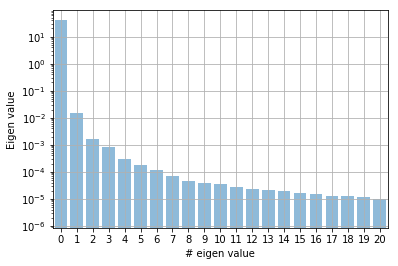

In [271]:
plt.bar(range(len(eig_vals)), eig_vals, log=True, alpha=0.5)
plt.xticks(features)
plt.xlabel("# eigen value")
plt.ylabel("Eigen value")
plt.xlim(-0.5,20.5)
plt.grid()
plt.show()

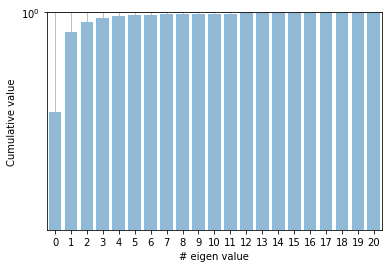

In [277]:
cum_vals = np.cumsum(eig_vals)/np.sum(eig_vals)
plt.bar(range(len(eig_vals)), cum_vals, log=True, alpha=0.5)
plt.xticks(features)
plt.xlabel("# eigen value")
plt.ylabel("Cumulative value")
plt.xlim(-0.5,20.5)
plt.ylim(0.999,1)
plt.grid()
plt.show()

In [255]:
print(eig_pairs[0][1].shape)

matrix_w = np.hstack((eig_pairs[0][1].reshape(40,1), 
                      eig_pairs[1][1].reshape(40,1),
                      eig_pairs[2][1].reshape(40,1)))

print('Matrix W:\n', matrix_w)

(40,)
Matrix W:
 [[-0.15808636  0.2285235   0.05340326]
 [-0.15814081  0.06455348  0.07111292]
 [-0.15812458 -0.1041831   0.11722674]
 [-0.15810562 -0.18062696 -0.00442365]
 [-0.15809796 -0.19375559  0.22217315]
 [-0.15809889  0.2037846   0.04093441]
 [-0.1581309   0.07904827 -0.22771023]
 [-0.15814699  0.01067923 -0.06781592]
 [-0.15813506 -0.0881962   0.03284503]
 [-0.15813743 -0.08371947 -0.09561286]
 [-0.1579728   0.37889569 -0.16051413]
 [-0.15812081  0.15251393 -0.03987658]
 [-0.15814635  0.02344965  0.10436052]
 [-0.15814397 -0.03078575  0.13071967]
 [-0.15814058 -0.06653094  0.05779307]
 [-0.15797052  0.38549951  0.11955887]
 [-0.15811479  0.15021225  0.24422781]
 [-0.15814348  0.05279762 -0.12120896]
 [-0.15814398 -0.02115892 -0.11040917]
 [-0.15814574 -0.04386138  0.04441063]
 [-0.15809491  0.20103627  0.11665943]
 [-0.15814117 -0.02516797 -0.01842735]
 [-0.15814014 -0.03220164 -0.22103735]
 [-0.15813159 -0.115365    0.07768627]
 [-0.15808178 -0.13040086 -0.58650803]
 [-0.158

In [286]:
Y = X_std.dot(matrix_w)
print(Y)

[[ 1.35393350e+00 -1.61392430e-03 -1.52175494e-02]
 [ 1.37107840e+00 -4.94285237e-03 -6.78011935e-03]
 [ 9.06889643e-01 -3.26327804e-03 -8.47100432e-02]
 ...
 [-1.42523311e+01  4.97188748e-01  9.42114434e-04]
 [ 1.39248609e+00 -2.25415203e-03  8.99266153e-03]
 [ 1.40202619e+00 -1.03086798e-03  1.55981018e-02]]


In [311]:
# Reconstruct SVD
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
from scipy.linalg import svd
# define a matrix
A = array([[1, 2], [3, 4], [5, 6], [1, 7], [3, 8], [5, 9]]).T
print(A.shape)
print(A.T)
# Singular-value decomposition
U, s, VT = svd(A)
# create m x n Sigma matrix
Sigma = zeros((A.shape[0], A.shape[1]))
# populate Sigma with n x n diagonal matrix
Sigma[:A.T.shape[1], :A.T.shape[1]] = diag(s)
# reconstruct matrix
B = U.dot(Sigma.dot(VT))
print(B.T)

(2, 6)
[[1 2]
 [3 4]
 [5 6]
 [1 7]
 [3 8]
 [5 9]]
[[1. 2.]
 [3. 4.]
 [5. 6.]
 [1. 7.]
 [3. 8.]
 [5. 9.]]
